In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.metrics import mean_squared_error

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import numpy as np
import seaborn as sns

In [2]:
airline_data = pd.read_csv("dom_citypairs_web.csv")

In [39]:
data = pd.read_csv("dom_citypairs_web.csv", parse_dates = [[10, 11]], infer_datetime_format = True, index_col = 0)
data.sample(10)

,City1,City2,Month,Passenger_Trips,Aircraft_Trips,Passenger_Load_Factor,Distance_GC_(km),RPKs,ASKs,Seats
Year_Month_num,,,,,,,,,,
1991-05-01,MELBOURNE,MILDURA,33359,2663,260,43.2,457,1216991.0,2817109.0,6164
2004-01-01,CAIRNS,TOWNSVILLE,37987,6531,305,54.72599296,284,1854804.0,3389256.0,11934
2014-01-01,DEVONPORT,MELBOURNE,41640,0,0,0,412,0.0,0.0,0
2003-07-01,HOBART,MELBOURNE,37803,60375,700,70.1,618,37311750.0,53254914.0,86173
2017-04-01,BRISBANE,CAIRNS,42826,118045,884,82,1391,164200595.0,200224713.0,143943
2003-08-01,LAUNCESTON,SYDNEY,37834,4523,62,62.8,914,4134022.0,6578058.0,7197
2019-12-01,PERTH,PORT HEDLAND,43800,29642,379,59.9,1312,38890304.0,64888896.0,49458
1995-02-01,BRISBANE,CANBERRA,34731,12895,279,56.2,956,12327620.0,21944024.0,22954
2014-07-01,ADELAIDE,CANBERRA,41821,13659,180,59.4,972,13276548.0,22340448.0,22984


In [40]:
# Choosing the desired columns - 
data = data[["City1", "City2", "Passenger_Trips"]]
data.head()

,City1,City2,Passenger_Trips
Year_Month_num,,,
1984-01-01,ADELAIDE,ALICE SPRINGS,15743
1984-01-01,ADELAIDE,BRISBANE,3781
1984-01-01,ADELAIDE,CANBERRA,1339
1984-01-01,ADELAIDE,DARWIN,3050
1984-01-01,ADELAIDE,GOLD COAST,1596


In [5]:
# Filter according to City2 here - 

In [41]:
# Aggregating to total total passengers in each month -
total_passengers = data.groupby([data.index]).agg({"Passenger_Trips" : "sum"})
total_passengers.head()

,Passenger_Trips
Year_Month_num,
1984-01-01,800530
1984-02-01,660289
1984-03-01,739785
1984-04-01,770776
1984-05-01,813317


In [50]:
temp = total_passengers["Passenger_Trips"].rolling(12).mean().dropna()
temp.head()

Year_Month_num
1984-12-01    772094.333333
1985-01-01    775948.666667
1985-02-01    777274.583333
1985-03-01    782388.583333
1985-04-01    785351.333333
Name: Passenger_Trips, dtype: float64

In [51]:
temp = temp["2000":'2020']

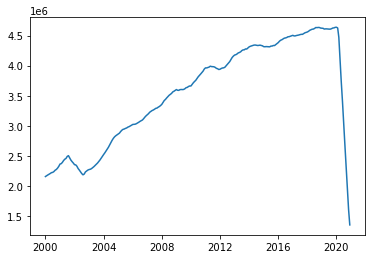

In [52]:
plt.plot(temp)

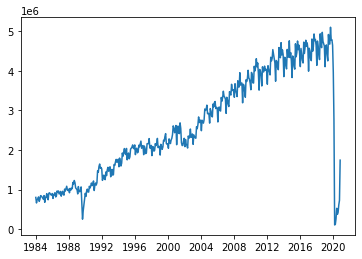

In [7]:
plt.plot(total_passengers["Passenger_Trips"])

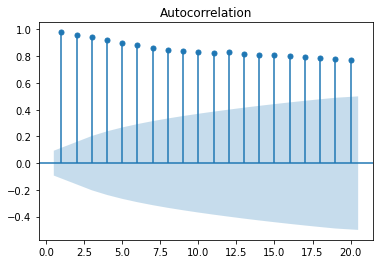

In [8]:
# ACF PACF - 
plot_acf(total_passengers["Passenger_Trips"], lags = 20, zero = False)
plt.show()

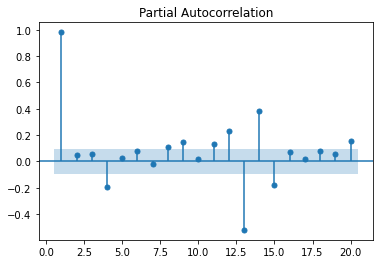

In [9]:
plot_pacf(total_passengers["Passenger_Trips"], lags = 20, zero = False)
plt.show()

In [10]:
# ADF Test - 
results = adfuller(total_passengers["Passenger_Trips"])
print(f"The p-statistic from the ADFuller test is - {round(results[1], 4)}")
if results[1] > 0.05:
    print("Based on p-value we can say that the series is non-stationary.")
else:
    print("Based on p-value we can say that the series is stationary.")


The p-statistic from the ADFuller test is - 0.4683
Based on p-value we can say that the series is non-stationary.


In [11]:
# EXPLORING MULTIPLICATIVE AND ADDITIVE DECOMPOSITIONS - 

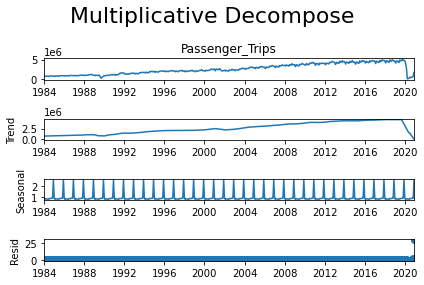

In [12]:
# Decomposing the time-series -
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Multiplicative Decomposition 
result_mul = seasonal_decompose(total_passengers["Passenger_Trips"], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(total_passengers["Passenger_Trips"], model='additive', extrapolate_trend='freq')

# Plot
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
plt.tight_layout()
plt.show()

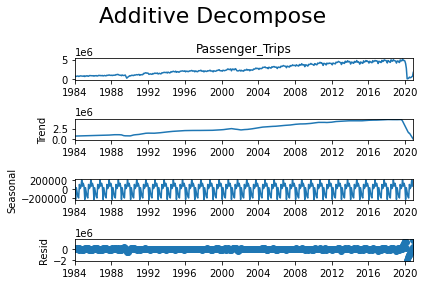

In [13]:
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.tight_layout()
plt.show()

In [14]:
# From the 2-graphs we can say that multiplicative decomposition is better for our data.
# Checking the ADFuller test for the same.
adf_res = adfuller(result_mul.resid)
print(f"The p-statistic from the ADFuller test is - {round(adf_res[1], 4)}")
if adf_res[1] > 0.05:
    print("Based on p-value we can say that the series is non-stationary.")
else:
    print("Based on p-value we can say that the series is stationary.")


The p-statistic from the ADFuller test is - 0.0001
Based on p-value we can say that the series is stationary.


In [15]:
# Given the findings above, we decide to go for log transformation and differencing the series to stationarize it.
total_passengers["Transformed"] = np.log(total_passengers["Passenger_Trips"]).diff()
total_passengers.dropna(inplace=True)
total_passengers.head()

,Passenger_Trips,Transformed
Year_Month_num,,
1984-02-01,660289,-0.192596
1984-03-01,739785,0.113682
1984-04-01,770776,0.041038
1984-05-01,813317,0.053723
1984-06-01,700510,-0.149312


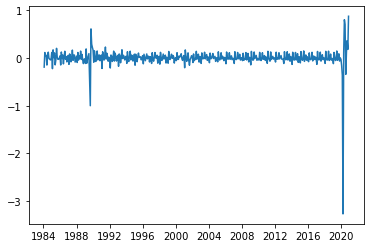

In [16]:
# Confirming with plot and ADFuller test - 
plt.plot(total_passengers["Transformed"])
plt.show()

In [17]:
adf_res = adfuller(total_passengers["Transformed"])
print(f"The p-statistic from the ADFuller test is - {round(adf_res[1], 4)}")
if adf_res[1] > 0.05:
    print("Based on p-value we can say that the series is non-stationary.")
else:
    print("Based on p-value we can say that the series is stationary.")

The p-statistic from the ADFuller test is - 0.0
Based on p-value we can say that the series is stationary.


In [18]:
# Now our seriers is ready for modelling.

In [19]:

i_range = 3
j_range = 2
k_range = 1

total = i_range * j_range * k_range
print(total)
count = 0
for i in range(i_range):
    for j in range(j_range):
        for k in range(k_range):
            print(i, j ,k)
            count = count+1
            print(f"{round(count/total * 100, 4)} % Completed")

6
0 0 0
16.6667 % Completed
0 1 0
33.3333 % Completed
1 0 0
50.0 % Completed
1 1 0
66.6667 % Completed
2 0 0
83.3333 % Completed
2 1 0
100.0 % Completed


In [20]:
data['year'] = [d.year for d in data.index]
data['month'] = [d.strftime('%b') for d in data.index]
years = data['year'].unique()
data.head()

,City1,City2,Passenger_Trips,year,month
Year_Month_num,,,,,
1984-01-01,ADELAIDE,ALICE SPRINGS,15743,1984,Jan
1984-01-01,ADELAIDE,BRISBANE,3781,1984,Jan
1984-01-01,ADELAIDE,CANBERRA,1339,1984,Jan
1984-01-01,ADELAIDE,DARWIN,3050,1984,Jan
1984-01-01,ADELAIDE,GOLD COAST,1596,1984,Jan


In [21]:
total_passengers['year'] = [d.year for d in total_passengers.index]
total_passengers['month'] = [d.strftime('%b') for d in total_passengers.index]
years = total_passengers['year'].unique()
total_passengers.head()

,Passenger_Trips,Transformed,year,month
Year_Month_num,,,,
1984-02-01,660289,-0.192596,1984,Feb
1984-03-01,739785,0.113682,1984,Mar
1984-04-01,770776,0.041038,1984,Apr
1984-05-01,813317,0.053723,1984,May
1984-06-01,700510,-0.149312,1984,Jun


In [26]:
temp = total_passengers["2000":"2020"]
temp.head()

,Passenger_Trips,Transformed,year,month
Year_Month_num,,,,
2000-01-01,2160635,0.006659,2000,Jan
2000-02-01,2044303,-0.055345,2000,Feb
2000-03-01,2282132,0.110053,2000,Mar
2000-04-01,2230345,-0.022954,2000,Apr
2000-05-01,2162880,-0.030716,2000,May


In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10,7), dpi= 80)
sns.boxplot(x='year', y='Passenger_Trips', data=temp,
            ax=axes)

axes.set_title('Year-wise Box Plot\n(The Trend)', fontsize=18)
plt.show()

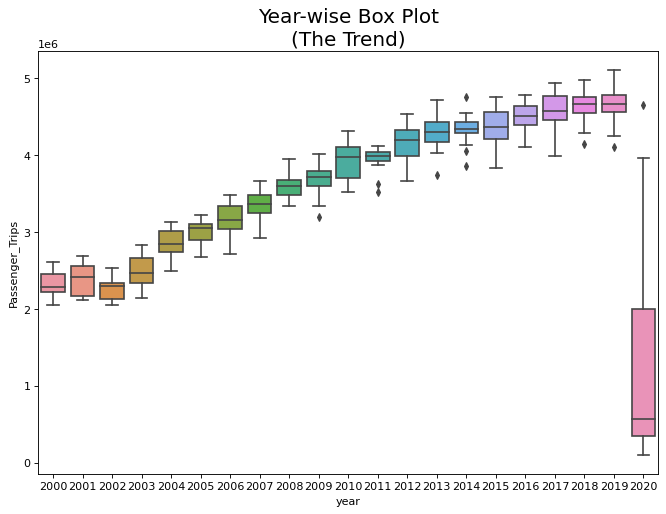

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(10,7), dpi= 80)
sns.boxplot(x='year', y='Passenger_Trips', data=temp,
            ax=axes)
# sns.boxplot(x='month', y='Passenger_Trips', data=temp)
axes.set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
#axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [37]:
temp = total_passengers["2016":"2019"]
temp.head()

,Passenger_Trips,Transformed,year,month
Year_Month_num,,,,
2016-01-01,4444139,-0.045665,2016,Jan
2016-02-01,4109247,-0.078346,2016,Feb
2016-03-01,4568852,0.106022,2016,Mar
2016-04-01,4426706,-0.031606,2016,Apr
2016-05-01,4269438,-0.036174,2016,May


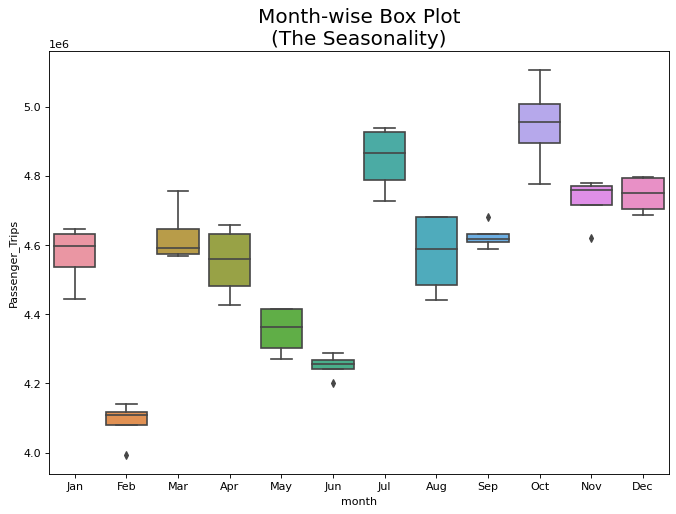

In [38]:
fig, axes = plt.subplots(1, 1, figsize=(10,7), dpi= 80)
sns.boxplot(x='month', y='Passenger_Trips', data=temp)
axes.set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [ ]:
fig, axes = plt.subplots(figsize=(10,7), dpi= 80)
axes.set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)

In [ ]:
# Sequence input - X, Y
# Option 2010 to 2020 March
# Train , test data - 
# Train the model
# Predict
# Show the graph


In [102]:
# City-wise box-plots
temp = data[data['City2'] == "SYDNEY"]
temp = temp.groupby(temp.index).agg({"Passenger_Trips" : "sum"})
temp.head()

,Passenger_Trips
Year_Month_num,
1984-01-01,394432
1984-02-01,372287
1984-03-01,408661
1984-04-01,407946
1984-05-01,434844


In [103]:

temp['year'] = [d.year for d in temp.index]
temp['month'] = [d.strftime('%b') for d in temp.index]
years = temp['year'].unique()
temp = temp[temp["year"] > 1999]
temp.head()

,Passenger_Trips,year,month
Year_Month_num,,,
2000-01-01,1195139,2000,Jan
2000-02-01,1170720,2000,Feb
2000-03-01,1293380,2000,Mar
2000-04-01,1238318,2000,Apr
2000-05-01,1212144,2000,May


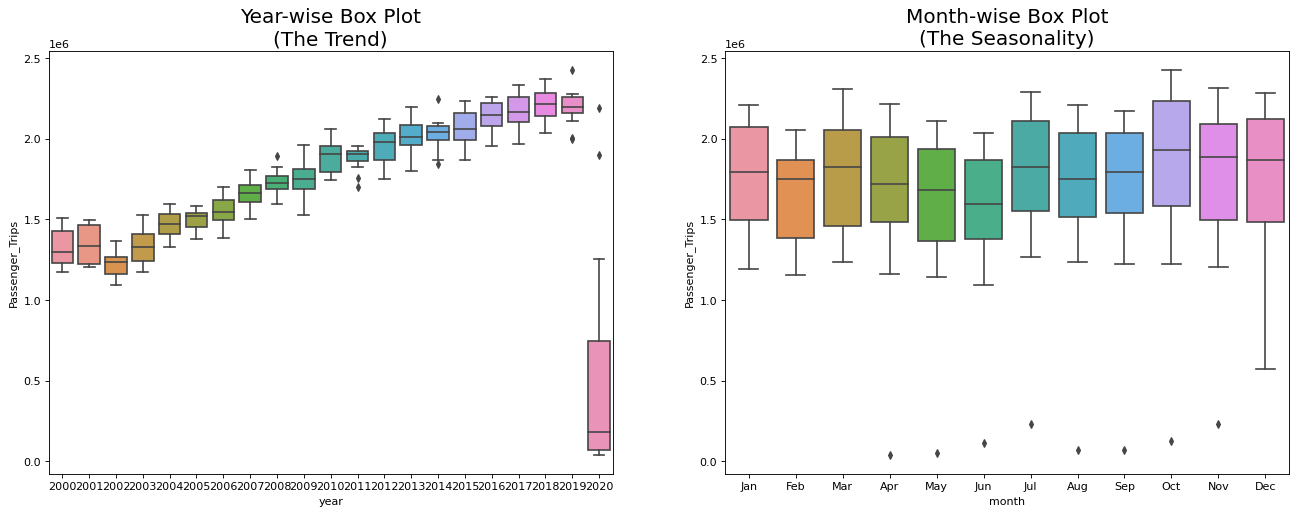

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Passenger_Trips', data=temp,
            ax=axes[0])
sns.boxplot(x='month', y='Passenger_Trips', data=temp)
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [19]:
# Multiplicative was better -
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
Year_Month_num,,,,
1984-01-01,0.890654,742292.936966,1.210858,800530.0
1984-02-01,0.785285,747046.135684,1.125536,660289.0
1984-03-01,0.870509,751799.334402,1.130395,739785.0
1984-04-01,0.835762,756552.533120,1.219008,770776.0
1984-05-01,0.805482,761305.731838,1.326310,813317.0


In [20]:
# Checking with adfuller - 
adfuller(df_reconstructed["resid"])

(-4.720760823688771,
 7.691193480342379e-05,
 18,
 425,
 {'1%': -3.445830555854264,
  '5%': -2.8683646683004276,
  '10%': -2.570405316262976},
 1190.3908160156748)

In [26]:
# Statistically checking for stationarity - 
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(total_passengers["Passenger_Trips"].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# KPSS Test
result = kpss(total_passengers["Passenger_Trips"].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -1.628507893046367
p-value: 0.4682718378496302

KPSS Statistic: 2.109835
p-value: 0.010000


/Users/riteshsuhag/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/riteshsuhag/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


In [ ]:
# We can see that the series is not stationary.

In [ ]:
# De-trending the time-series using stats_model component.

In [ ]:
# airline_data.head()
agg_data = airline_data.groupby(["Year", "Month_num"]).agg({"Passenger_Trips" : "sum"}).reset_index()
agg_data.head()
plt.plot(agg_data["Passenger_Trips"])